In [ ]:
import os
new_directory = "/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/HACCnPaint/Cores/PaintCores_lcx/"  # Replace with the actual path
os.chdir(new_directory)

import numpy as np
import h5py

# %%
import numexpr
# numexpr.set_num_threads(min(8, numexpr.detect_number_of_cores()))
numexpr.set_num_threads(64)

import time
time0 = time.time()
import glob
import pandas as pd

import matplotlib.pyplot as plt
# import haccytrees.mergertrees
# import pygio
# import os

# os.environ["CUDA_32VISIBLE_DEVICES"] = ""

import simulation_models
# import cosmology_utils
# import cores_analysis
import plot_utils
# import lightcone_tree_matching
# import bpl_analysis
import painting
import catalog_io
import yaml_read
import photometry
# import scipy.spatial


%matplotlib inline


# from mpi4py import MPI
from numba import config
config.THREADING_LAYER = 'workqueue'

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

In [ ]:
config = yaml_read.yaml_config('config_LJ.yml')
target_skypatch_id = config['hacc_simulation']['skypatchID']
target_skypatch_id = 30
print(target_skypatch_id)

30


In [ ]:
def load_matches_from_h5(output_file):
    combined_data = {}
    with h5py.File(output_file, "r") as f:
        for core_key in f.keys():
            for key in f[core_key].keys():
                if key not in combined_data:
                    combined_data[key] = []
                combined_data[key].append(f[core_key][key][...])
    # Concatenate lists of arrays into single arrays for each key
    for key in combined_data:
        combined_data[key] = np.concatenate(combined_data[key], axis=0)
    return combined_data

output_file = f"../PaintCores_lcx/mocks/finished_mocks/supermock_lightcone_skypatch_{target_skypatch_id}.h5"
# Load matches_for_lc from the HDF5 file
matches_for_lc = load_matches_from_h5(output_file)

print('Available match keys: ', matches_for_lc.keys())
print('Matches: ', matches_for_lc['x'].shape, 'Skypatch: ', target_skypatch_id)

Available match keys:  dict_keys(['central', 'core_state', 'core_tag', 'dec', 'fof_halo_tag', 'merged', 'peak_mass', 'ra', 'rank_peak_mass', 'redshift', 'sfh', 'stellar_mass', 't25_a1', 't50_a1', 'time_infall', 'vx', 'vy', 'vz', 'x', 'y', 'z'])
Matches:  (36058290,) Skypatch:  30


In [ ]:
cosmo = simulation_models.get_cosmo(config['hacc_simulation']['name'])

In [ ]:
match_redshift = matches_for_lc['redshift'][:1000]
match_sfh = matches_for_lc['sfh'][:, np.newaxis, :][:1000]

In [ ]:
match_sfh.shape, match_redshift.shape, matches_for_lc['peak_mass'].shape, matches_for_lc['stellar_mass'].shape

((1000, 1, 117), (1000,), (36058290,), (36058290,))

/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/HACCnPaint/Cores/PaintCores_lcx/plot_utils.py:406: RuntimeWarning: invalid value encountered in log10
  corner.hist2d( x=np.log10(Mpeak),


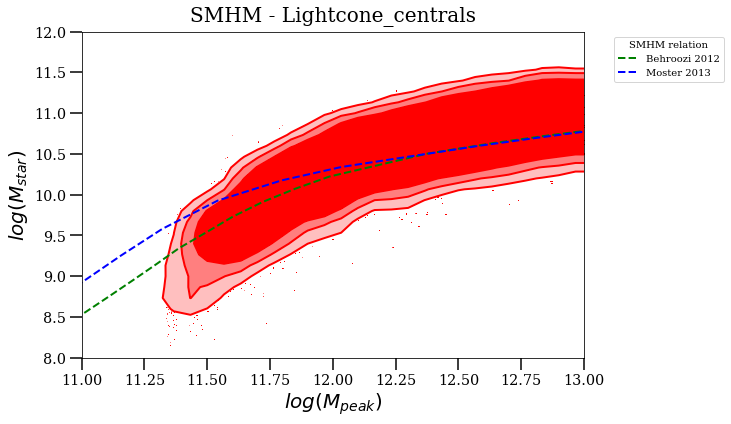

<Figure size 432x288 with 0 Axes>

In [ ]:
# plt.hist(np.log10(matches_for_lc['peak_mass']), alpha=0.5, bins=100);
plot_utils.plot_SMHM_comparison(matches_for_lc['peak_mass'][::1], matches_for_lc['stellar_mass'][::1], 'Lightcone_centrals')
# plt.hist(matches_for_lc['redshift'], alpha=0.5, bins=100);
# plot_utils.basemap_plot(matches_for_lc['ra'], matches_for_lc['dec'])
# plt.hist(np.log10(matches_for_lc[0]['stellar_mass']), alpha=0.5, bins=100);
# plt.plot(matches_for_lc['sfh'][0:10].T, alpha=0.5); 
# plt.yscale('log')
# plt.ylim(1e-3, )

In [ ]:
# plt.hist(np.log10(matches_for_lc['peak_mass']), alpha=0.5, bins=100);
# plot_utils.plot_SMHM_comparison(matches_for_lc['peak_mass'], matches_for_lc['stellar_mass'], 'Lightcone_centrals')
plt.hist(matches_for_lc['redshift'], alpha=0.5, bins=100);
# plot_utils.basemap_plot(matches_for_lc['ra'], matches_for_lc['dec'])
# plt.hist(np.log10(matches_for_lc[0]['stellar_mass']), alpha=0.5, bins=100);
# plt.plot(matches_for_lc['sfh'][0:10].T, alpha=0.5);

In [ ]:
mlp_central, scaler, scaler_y, wave, reds = painting.load_pretrained_models(config['painting_model']['model_dir'], 
                                                                            config['painting_model']['wavelength_dir'], 
                                                                            "Central")

## Painting Central

Loading the pre-processing pipeline from: /lcrc/project/cosmo_ai/nramachandra/Projects/Ulab_ldrd/emulator_utils/test/model/eline_input_scale_damp_central_z10.pkl
Loading the pre-processing pipeline from: /lcrc/project/cosmo_ai/nramachandra/Projects/Ulab_ldrd/emulator_utils/test/model/eline_output_scale_damp_central_z10.pkl
Model loaded from: /lcrc/project/cosmo_ai/nramachandra/Projects/Ulab_ldrd/emulator_utils/test/model/spec_mlp_eline_damp_central_z10
0


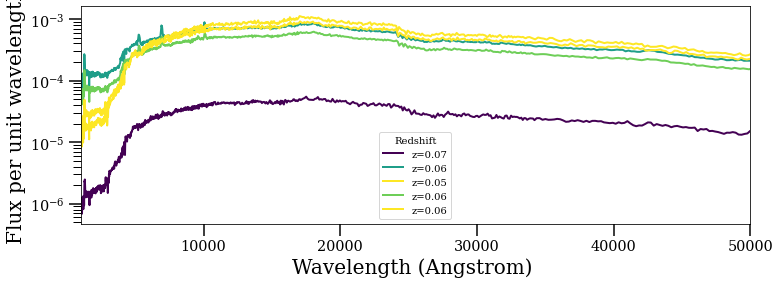

In [ ]:
mlp_central, scaler, scaler_y, wave, reds = painting.load_pretrained_models(config['painting_model']['model_dir'], 
                                                                            config['painting_model']['wavelength_dir'], 
                                                                            "Central")

######################

plot_frequency = config['painting_model']['plot_frequency']
plot_frequency = 1

######################
pcolor_all, wave_unnred, redshift_in, sfh_in = painting.paint_sed(mlp_central, scaler, scaler_y, 
                                                                  match_redshift, match_sfh, 
                                                                  wave, reds, plot_frequency)


match_lum = painting.calc_luminosity(pcolor_all, wave_unnred, redshift_in, cosmo, config['painting_model']['wave_min'], config['painting_model']['wave_max'])

# match_ra, match_dec = cosmology_utils.ra_dec(match_xyz[::plot_frequency, 0], 
#                              match_xyz[::plot_frequency, 1], 
#                              match_xyz[::plot_frequency, 2])

# plot_utils.plot_skymap(match_ra, match_dec, alphaq_sm[::plot_frequency, 0], match_lum, "Central")
plot_utils.plot_SED(pcolor_all, wave_unnred, redshift_in, config['painting_model']['wave_min'], config['painting_model']['wave_max'], "Central")

In [ ]:
pcolor_all.shape, wave_unnred.shape, redshift_in.shape, sfh_in.shape

((100, 1000, 921), (53545, 1963), (1, 1000), (117, 1000))

In [ ]:
# bandpassing SED to obtain colors

wave_lims = [config['painting_model']['wave_min'], config['painting_model']['wave_max']]

    
spherex_filter_pickle = config['painting_model']['spherex_filter_pickle']
lsst_filter_pickle = config['painting_model']['lsst_filter_pickle']
cosmos_filter_pickle = config['painting_model']['cosmos_filter_pickle']
wise_filter_pickle = config['painting_model']['wise_filter_pickle']
ls_filter_pickle = config['painting_model']['legacysurvey_filter_pickle']
mass2_filter_pickle = config['painting_model']['mass2_filter_pickle']
f784_filter_pickle = config['painting_model']['f784_filter_pickle']
all_filter_pickle = [spherex_filter_pickle, lsst_filter_pickle, cosmos_filter_pickle, wise_filter_pickle, ls_filter_pickle, mass2_filter_pickle, f784_filter_pickle]

In [ ]:
all_mags = photometry.photometric_bandpass(pcolor_all, wave_unnred, redshift_in, all_filter_pickle, wave_lims)
lsst_mags_central, spherex_mags_central, cosmos_mags_central, wise_mags_central, ls_mags_central, mass2_mags_central, f784_mags_central = all_mags

/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/HACCnPaint/Cores/PaintCores_lcx/painting.py:395: RuntimeWarning: divide by zero encountered in log10
  appmag_ext = -2.5*np.log10(flux)+23.9


In [ ]:
match_redshift_satellite = matches_for_lc['redshift'][:1000]
match_sfh_satellite = matches_for_lc['sfh'][:, np.newaxis, :][:1000]


In [ ]:
match_sfh_satellite.shape

(1000, 1, 117)

### Painting Satellites

Loading the pre-processing pipeline from: /lcrc/project/cosmo_ai/nramachandra/Projects/Ulab_ldrd/emulator_utils/test/model/eline_input_scale_damp_noncentral_z10.pkl
Loading the pre-processing pipeline from: /lcrc/project/cosmo_ai/nramachandra/Projects/Ulab_ldrd/emulator_utils/test/model/eline_output_scale_damp_noncentral_z10.pkl
Model loaded from: /lcrc/project/cosmo_ai/nramachandra/Projects/Ulab_ldrd/emulator_utils/test/model/spec_mlp_eline_damp_noncentral_z10
0


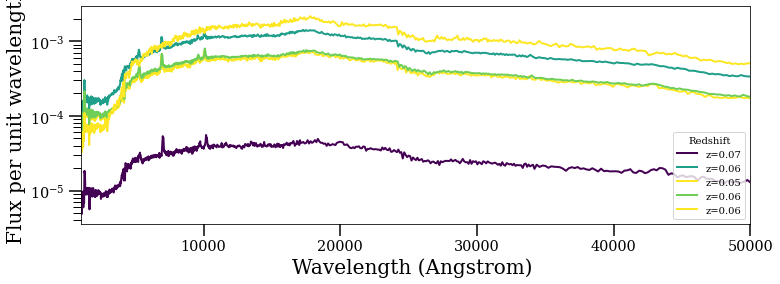

In [ ]:
mlp_satellite, scaler, scaler_y, wave, reds = painting.load_pretrained_models(config['painting_model']['model_dir'], 
                                                                              config['painting_model']['wavelength_dir'], 
                                                                              "Satellite")
######################
pcolor_all_satellite, wave_unnred_satellite, redshift_in_satellite, sfh_in_satellite = painting.paint_sed(mlp_satellite, scaler, scaler_y, 
                                                                  match_redshift_satellite, match_sfh_satellite, 
                                                                  wave, reds, plot_frequency)


match_lum_satellite = painting.calc_luminosity(pcolor_all_satellite, wave_unnred_satellite, redshift_in_satellite, cosmo, wave_min=config['painting_model']['wave_min'], wave_max=config['painting_model']['wave_max'])

# match_ra_satellite, match_dec_satellite = cosmology_utils.ra_dec(match_xyz_satellite[::plot_frequency, 0], 
#                              match_xyz_satellite[::plot_frequency, 1], 
#                              match_xyz_satellite[::plot_frequency, 2])

# plot_utils.plot_skymap(match_ra_satellite, match_dec_satellite, alphaq_sm_satellite[::plot_frequency, 0], match_lum_satellite, "Satellite")
plot_utils.plot_SED(pcolor_all_satellite, wave_unnred_satellite, redshift_in_satellite, config['painting_model']['wave_min'], config['painting_model']['wave_max'], "Satellite")

In [ ]:
all_mags = photometry.photometric_bandpass(pcolor_all_satellite, wave_unnred_satellite, redshift_in_satellite, all_filter_pickle, wave_lims)
lsst_mags_satellite, spherex_mags_satellite, cosmos_mags_satellite, wise_mags_satellite, ls_mags_satellite, mass2_mags_satellite, f784_mags_satellite = all_mags

/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/HACCnPaint/Cores/PaintCores_lcx/painting.py:395: RuntimeWarning: divide by zero encountered in log10
  appmag_ext = -2.5*np.log10(flux)+23.9


In [ ]:
sed_all = np.append(pcolor_all[0, :, :], pcolor_all_satellite[0, :, :], axis=0)
lum_all = np.append(match_lum, match_lum_satellite)
sed_wave_all = wave_unnred[:, np.where( (wave_unnred[0]>config['painting_model']['wave_min']) & (wave_unnred[0]<config['painting_model']['wave_max']))][0, 0, :]


lsst_mags_all = np.append(lsst_mags_central, lsst_mags_satellite ,axis=0)
spherex_mags_all = np.append(spherex_mags_central, spherex_mags_satellite, axis=0)
cosmos_mags_all = np.append(cosmos_mags_central, cosmos_mags_satellite, axis=0)
wise_mags_all = np.append(wise_mags_central, wise_mags_satellite, axis=0)
ls_mags_all = np.append(ls_mags_central, ls_mags_satellite, axis=0)
mass2_mags_all = np.append(mass2_mags_central, mass2_mags_satellite, axis=0)
f784_mags_all = np.append(f784_mags_central, f784_mags_satellite, axis=0)

In [ ]:
# sed_all.shape